**Package importation**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from pylab import rcParams

In [3]:
rcParams["figure.figsize"] = 30, 10

**Data Loading and Preview**

In [4]:
data = pd.read_csv("../data/raw_data.csv")
data.drop(columns=["index", "Patient Id"], inplace=True)

In [5]:
data.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,Low
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,High
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High


**Basic Data Analysis and Sanity Check**

In [6]:
print(
    f"The dataset has {data.shape[0]} records and {data.shape[1]} features \nThe feature set is composed by: {data.columns}"
)

The dataset has 1000 records and 24 features 
The feature set is composed by: Index(['Age', 'Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy',
       'OccuPational Hazards', 'Genetic Risk', 'chronic Lung Disease',
       'Balanced Diet', 'Obesity', 'Smoking', 'Passive Smoker', 'Chest Pain',
       'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath',
       'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails',
       'Frequent Cold', 'Dry Cough', 'Snoring', 'Level'],
      dtype='object')


It is important to understand that all features except for the Age are ordinal ones but not numerical.

In [7]:
data[np.setdiff1d(data.columns, "Age")] = data[np.setdiff1d(data.columns, "Age")].astype("category")

In [10]:
data["Level"].value_counts() / data.shape[0]

Level
High      0.365
Medium    0.332
Low       0.303
Name: count, dtype: float64

In [22]:
data[np.setdiff1d(data.columns, "Age")].describe()

,Air Pollution,Alcohol use,Balanced Diet,Chest Pain,Clubbing of Finger Nails,Coughing of Blood,Dry Cough,Dust Allergy,Fatigue,Frequent Cold,...,Obesity,OccuPational Hazards,Passive Smoker,Shortness of Breath,Smoking,Snoring,Swallowing Difficulty,Weight Loss,Wheezing,chronic Lung Disease
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,8,8,7,9,9,9,7,8,8,7,...,7,8,8,8,8,7,8,8,8,7
top,6,2,7,7,2,7,2,7,3,3,...,7,7,2,2,2,2,1,2,2,6
freq,326,202,296,296,240,187,251,405,212,230,...,356,365,284,243,222,300,221,280,240,308


In [26]:
print(f"The dataset has a total of {data.isna().sum().sum()} values which are NaN")

print(f"The dataset has a total of {data.duplicated().sum()} records, which corresponds to {100 * data.duplicated().sum() / data.shape[0]}% of all data")

The dataset has a total of 0 values which are NaN
The dataset has a total of 848 records, which corresponds to 84.8% of all data


This is an interesting finding! 

Given the dimension of the dataset, I will consider that the duplicates are not due to mistakes in the data gathering process.


We will now analyze, their relationship with the target variable "Level", through visualizations and hyphotesis testing.

/home/mariogomes/.cache/pypoetry/virtualenvs/mlops-project-LQNwQQj3-py3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


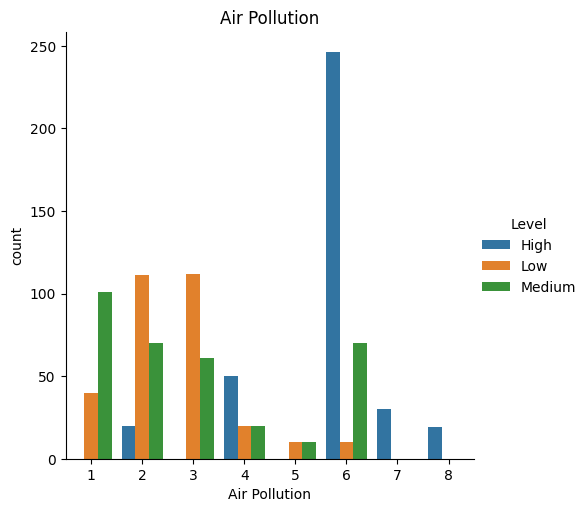

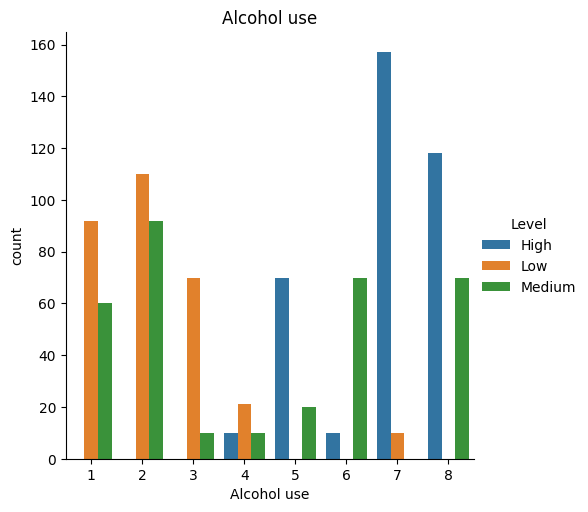

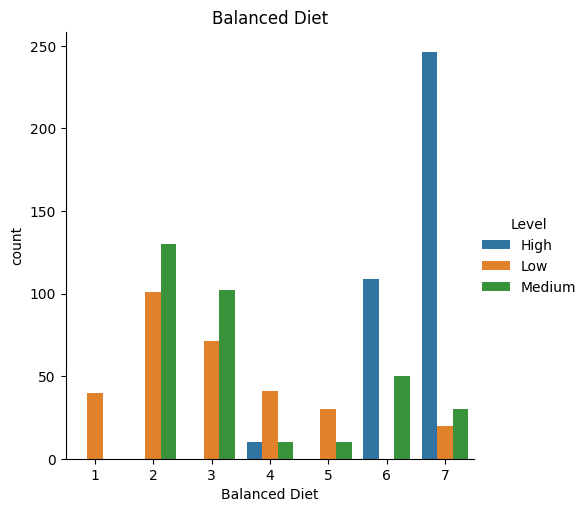

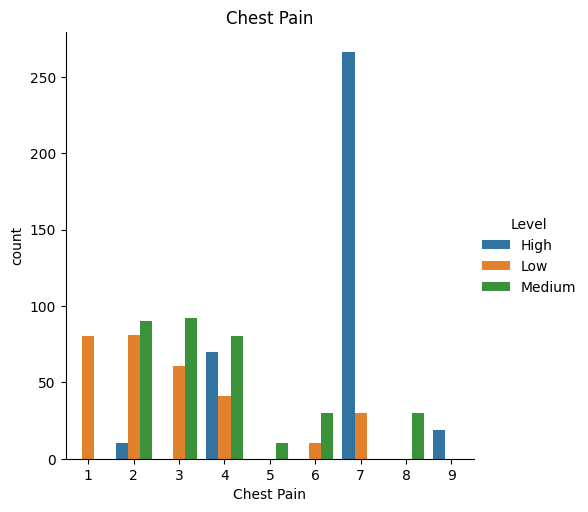

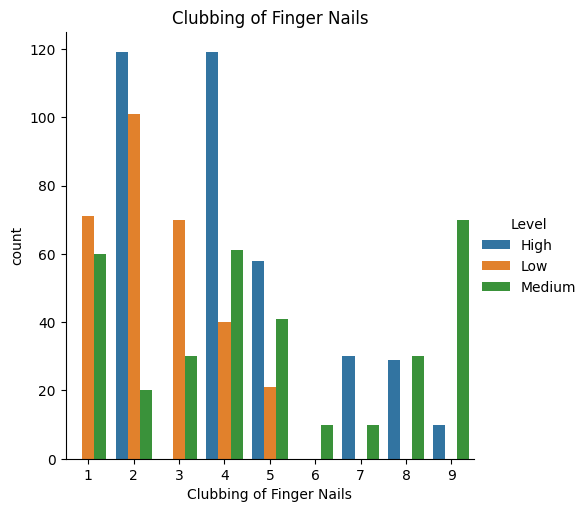

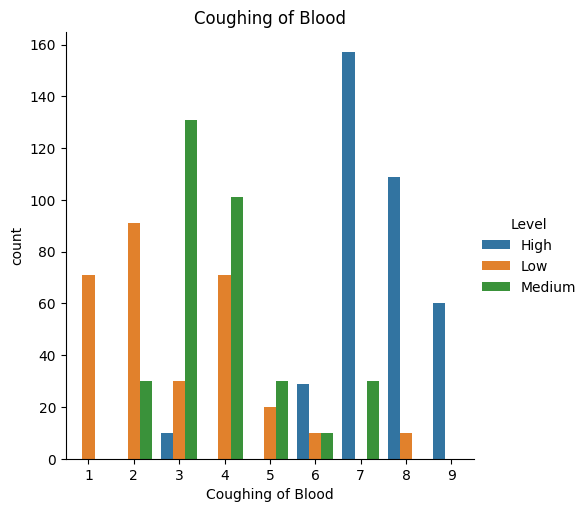

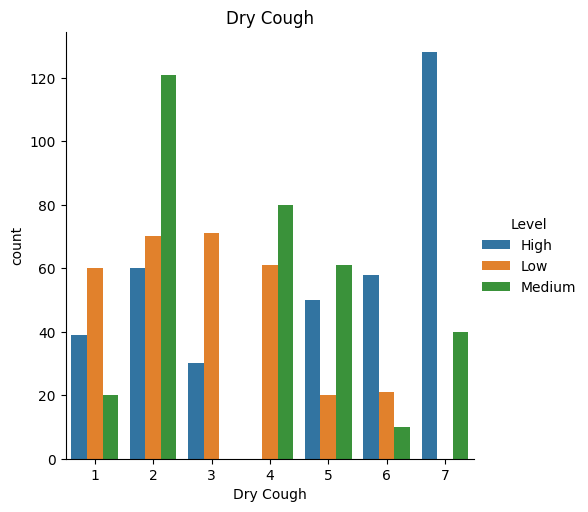

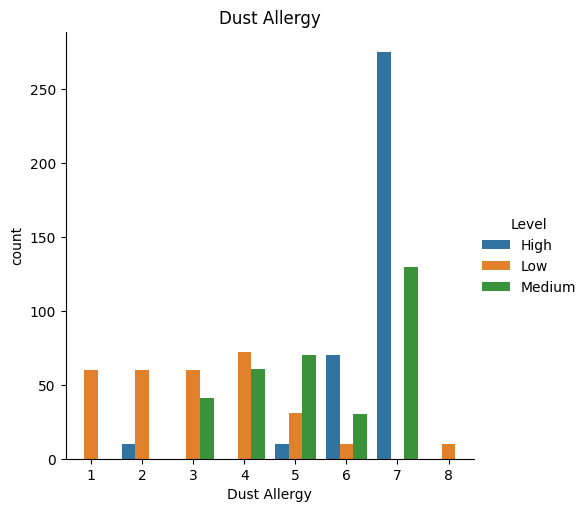

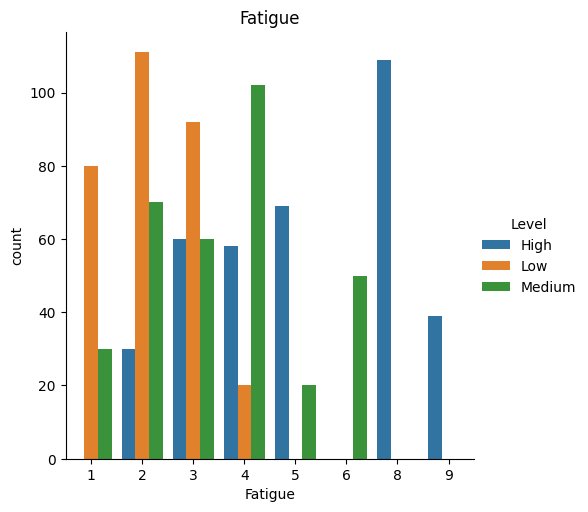

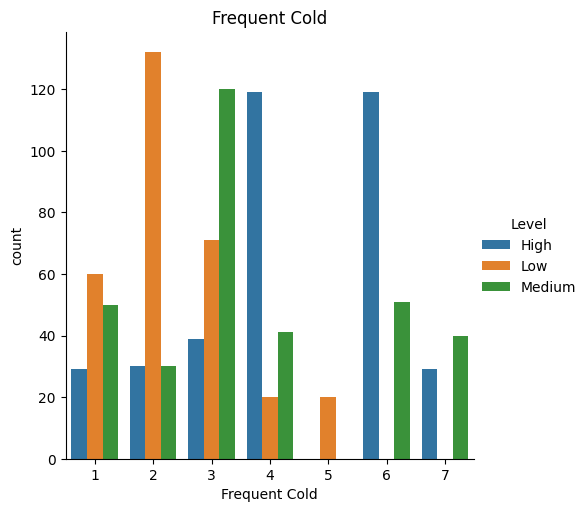

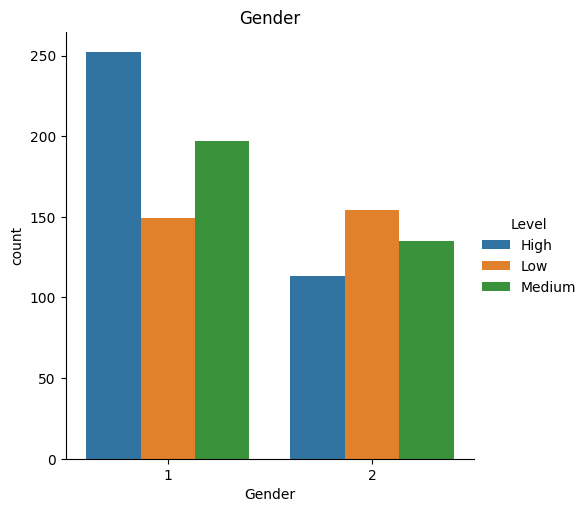

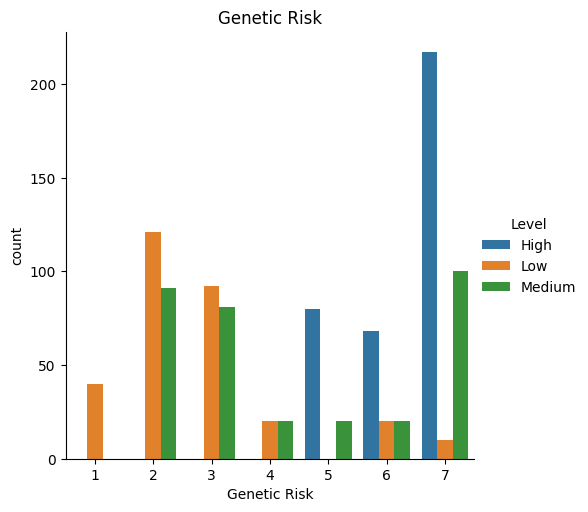

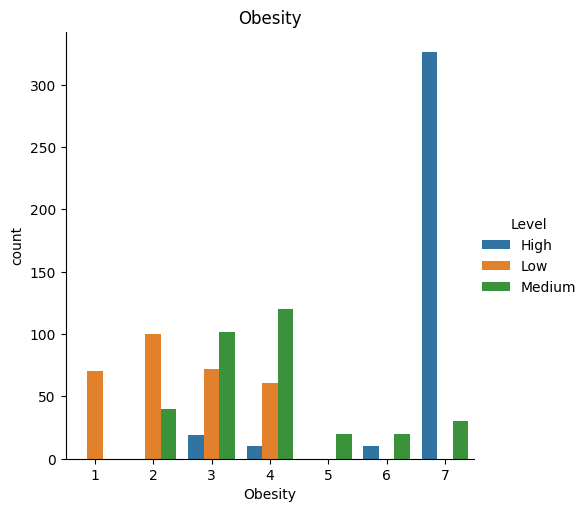

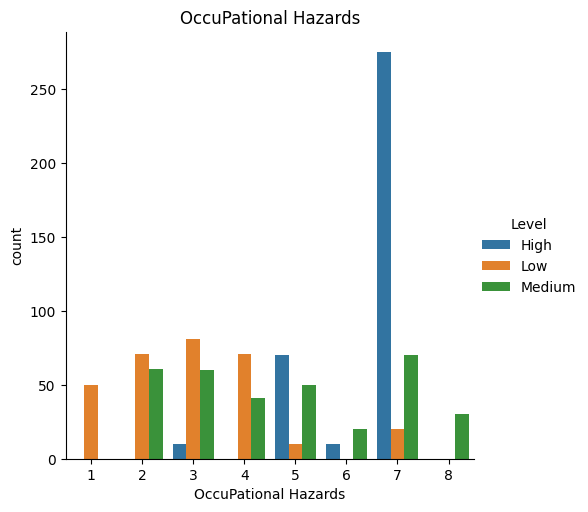

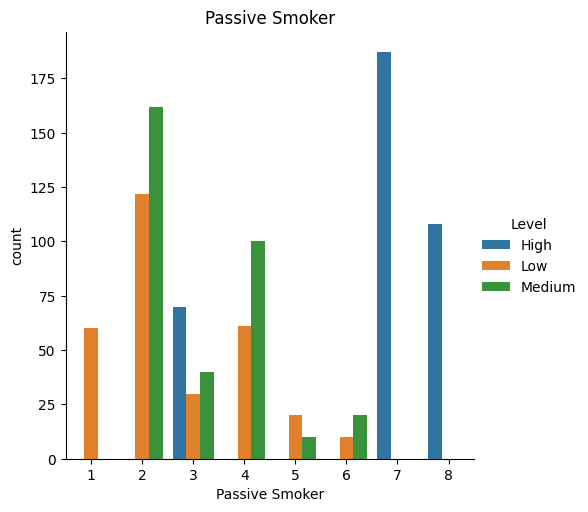

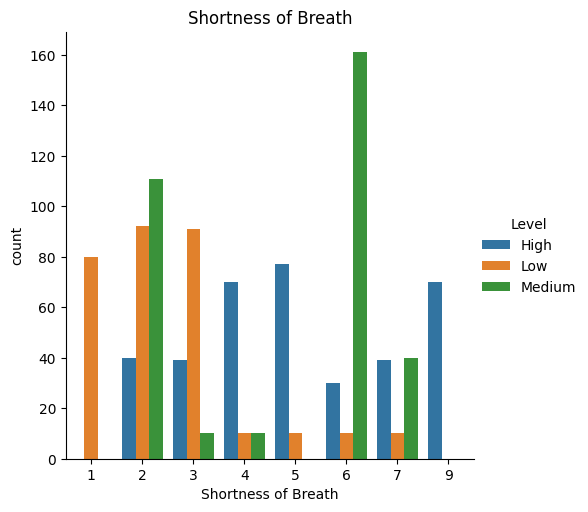

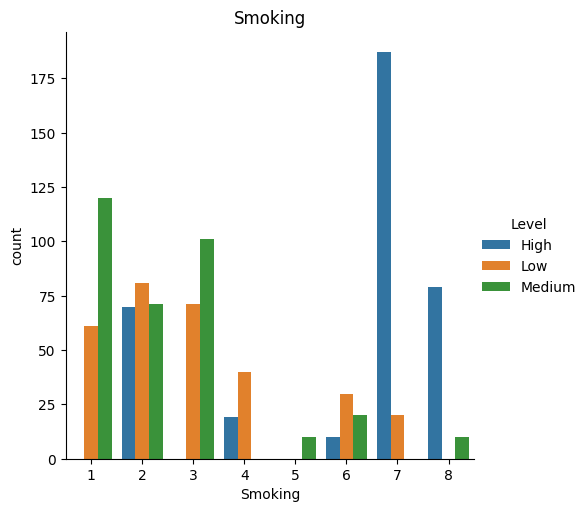

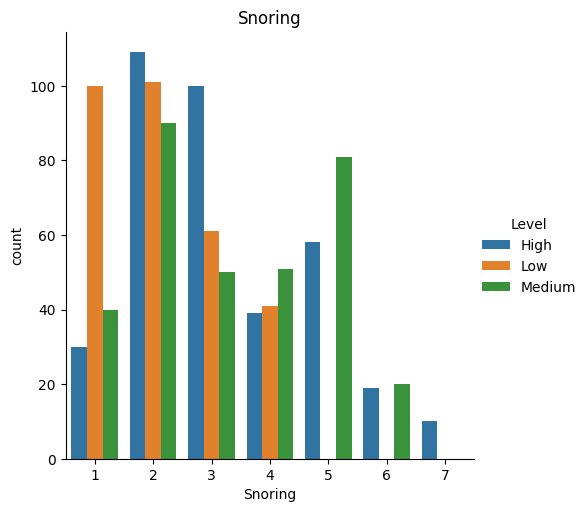

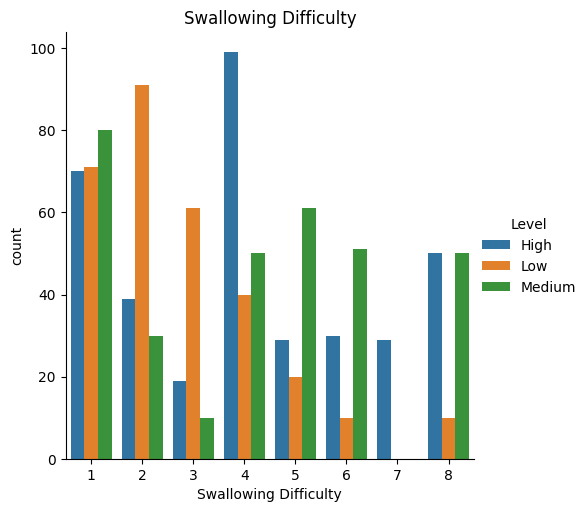

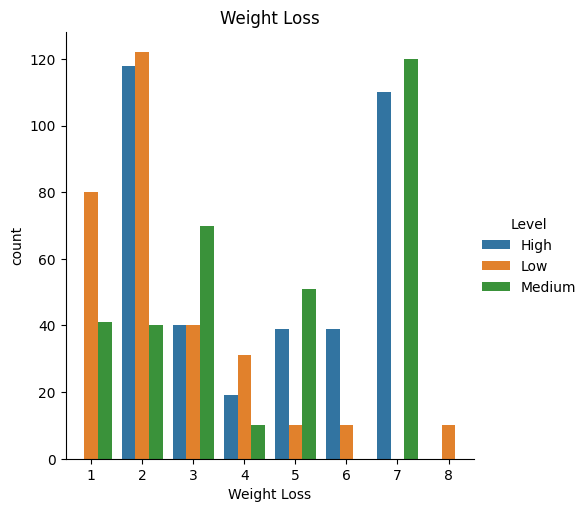

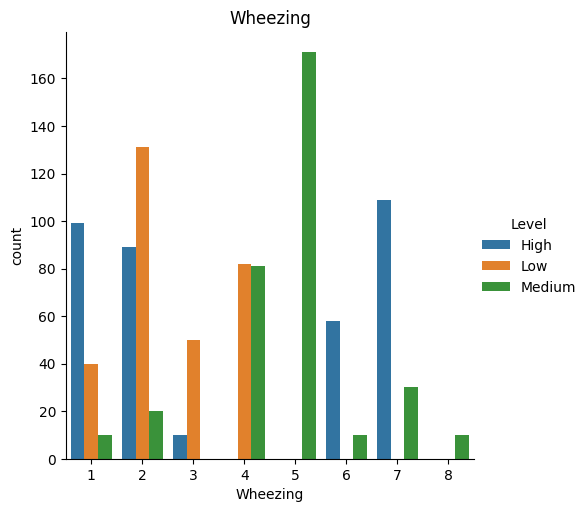

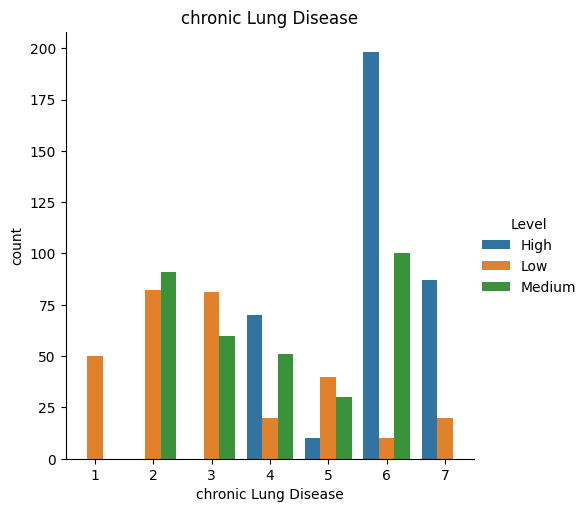

In [34]:
for thisFeature in np.setdiff1d(data.columns, ["Age", "Level"]):
    sns.catplot(
        data=data, 
        x=thisFeature, 
        hue="Level", 
        kind="count"
    ).set(title=f"{thisFeature}")
    

It is important to note that the majority of the features takes value in [1, ..., 9].

Even though some features found their maximum value to be 7 or 8, we will consider that the majority takes place in the same interval.

Nevertheless, the Gender feature only takes value of 1 or 2. We will need to address this later.

<Axes: xlabel='Age', ylabel='Density'>

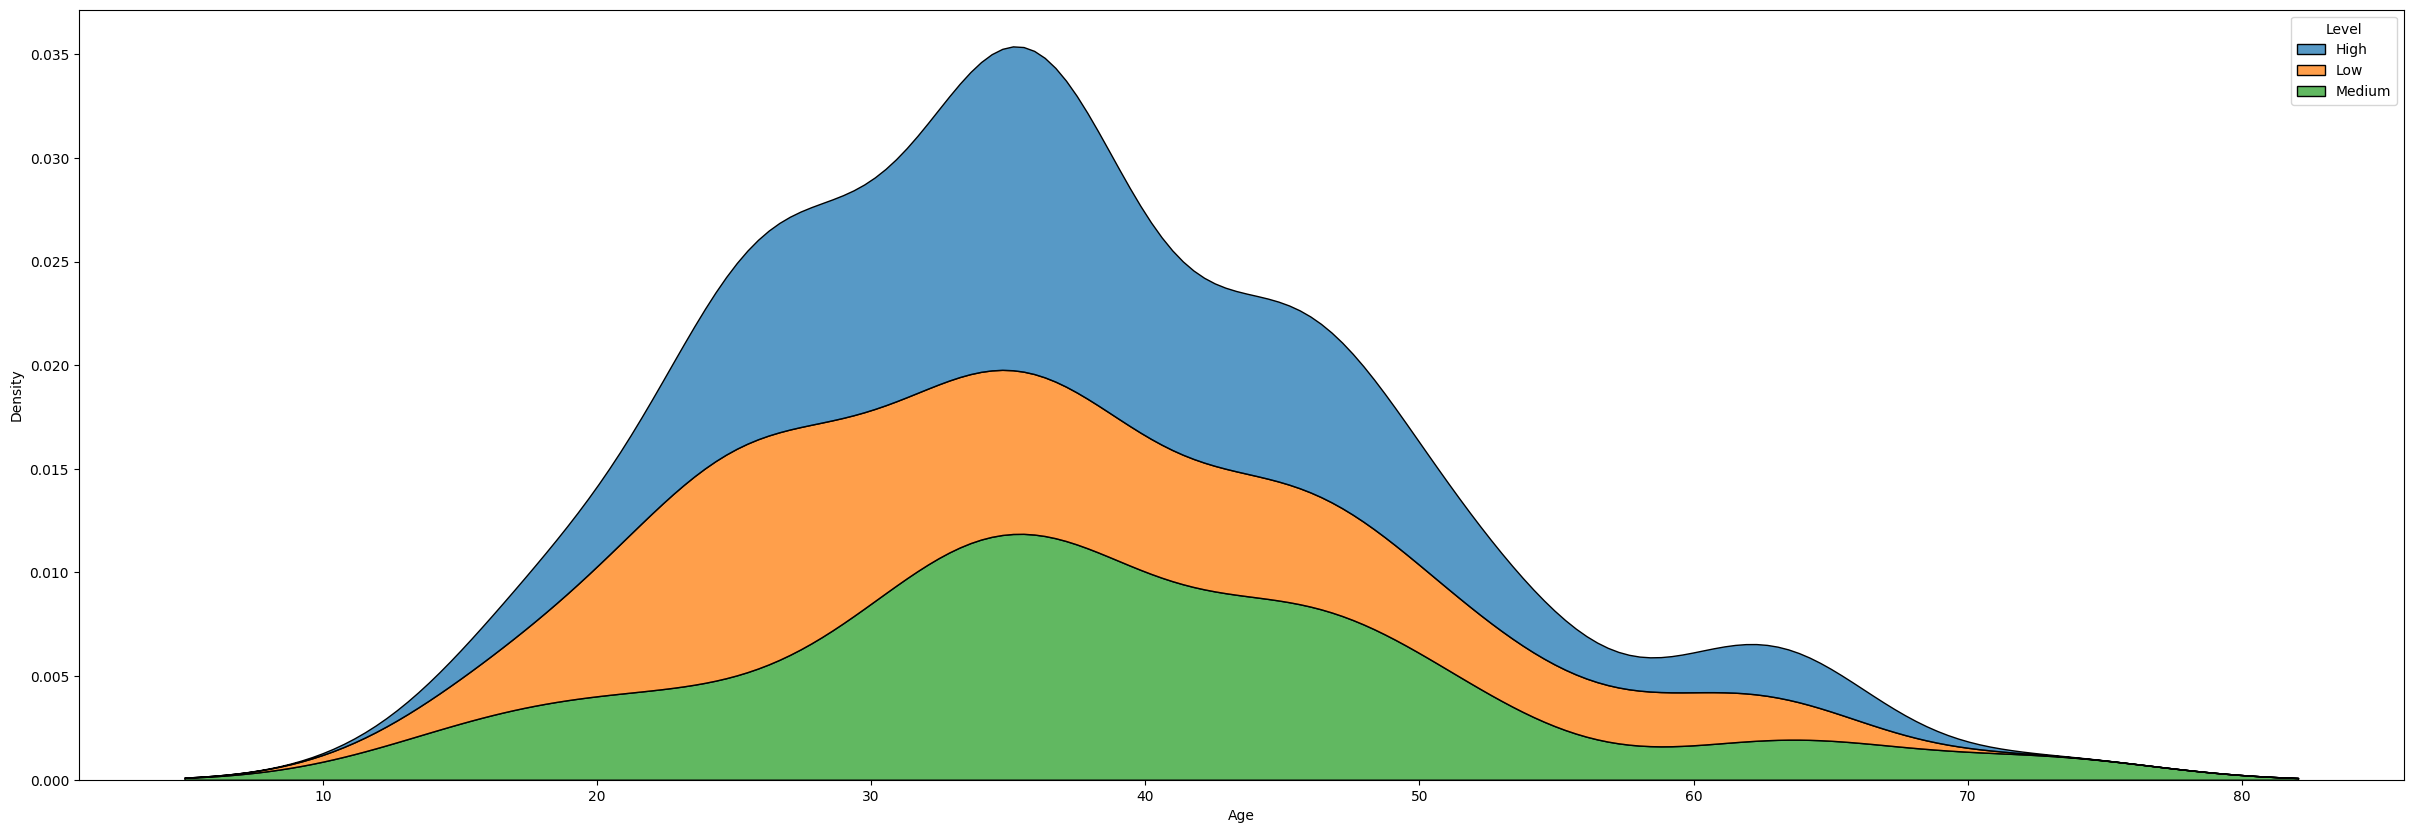

In [40]:
sns.kdeplot(
    data=data,
    x="Age",
    hue="Level",
    multiple="stack"
)



Is also important to note that the Age feature takes values in a range very different from the other features!

This is a problem that I will need to address later during preprocessing

**Feature Selection**

The dataset has 24 features, which can make it boring for a user to interact with it, when in production.

Given that the goal of this project is to build a ML system for production, I would like to reduce the number of considered features.

From the 24 features, I will select the best 7 features for predicting our target. In order to do so, I will use feature selection method: Recursive Feature Elimination with Random Forest Classifier.



In [60]:
# instantiate RandomForest Classifier with default parameters
estimator = RandomForestClassifier()
selector = RFECV(
    estimator=estimator,
    min_features_to_select=7,
    scoring="roc_auc_ovo",
    n_jobs=-1
)

In [61]:
# Cast target features to numerical for modelling
data["Level"] = data["Level"].replace(
    {"Low": 0, "Medium": 1, "High": 2}
)

X, y = data[np.setdiff1d(data.columns, "Level")], data["Level"]

In [62]:
selector = selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(f"The selected features were: {selected_features}")

The selected features were: Index(['Alcohol use', 'Coughing of Blood', 'Fatigue', 'Obesity',
       'Passive Smoker', 'Shortness of Breath', 'Wheezing'],
      dtype='object')


In [63]:
data = data[selected_features.to_list() + ["Level"]]

This finishes our minimal EDA.